## Step 0. Import Packages & Setup

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, Activation, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# mount gdrive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Please make a shortcut to `ads_proj4`. Right-click the `ads_proj4` folder in your Shared folder and make a shortcut to `My Drive`. 

In [3]:
# change root to the necessary path
root = "/gdrive/MyDrive/ads_proj4/ads-spring-2022-prj4-group-11-1/"
outputs_dir = root + "output/"

In [4]:
assert os.path.exists(root), 'Check the path to your root directory'
assert os.path.exists(outputs_dir), 'Check the path to your outputs directory'

## Step 1. Feature Engineering

In [68]:
compas_orig = pd.read_csv(root+'/data/compas-scores-two-years.csv')
compas_orig.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In the FFS paper, the authors did not use any juvenile offense features. Our baseline feature engineering was to use the same features as the FFS paper. 

### Juvenile Offense Counts

In [98]:
compas_orig['juv_count'] = compas_orig['juv_fel_count'] + compas_orig['juv_misd_count'] + compas_orig['juv_other_count']
compas_orig['adult_count'] = compas_orig['priors_count'] - compas_orig['juv_count']
compas_orig['juv_count'].value_counts()

0     6241
1      557
2      186
3      113
4       56
5       29
6        7
7        7
8        4
9        4
10       4
14       3
21       1
20       1
11       1
Name: juv_count, dtype: int64

In [99]:
juv = compas_orig.groupby(['juv_count']).agg({'two_year_recid': 'sum'})
juv['count'] = compas_orig['juv_count'].value_counts()
juv['prop'] = juv['two_year_recid'] / juv['count'] * 100
juv

,two_year_recid,count,prop
juv_count,,,
0,2573,6241,41.227367
1,370,557,66.427289
2,132,186,70.967742
3,85,113,75.221239
4,42,56,75.000000
5,22,29,75.862069
6,6,7,85.714286
7,4,7,57.142857
8,4,4,100.000000


### Priors Counts

In [87]:
priors = compas_orig.groupby(['priors_count']).agg({'two_year_recid': 'sum'})
priors['count'] = compas_orig['priors_count'].value_counts()
priors['prop'] = priors['two_year_recid'] / priors['count'] * 100
priors

,two_year_recid,count,prop
priors_count,,,
0,630,2150,29.302326
1,501,1397,35.862563
2,369,840,43.928571
3,295,568,51.936620
4,218,401,54.364090
5,187,334,55.988024
6,150,242,61.983471
7,131,210,62.380952
8,122,187,65.240642


In [88]:
compas_orig['juv_count'].corr(compas_orig['priors_count'])

0.26745521789221677

Correlation between juvenile counts and priors counts is low. We will go ahead and use juvenile offenses as features.

## Step 2. Data Processing

In [106]:
# loading data
compas = pd.read_csv(outputs_dir + 'ffs_data_v3.csv', header=0,
                     dtype = {'age_cat': int,'race': int,
                              'priors_count': int,'length_of_stay': int})
compas.head()

,age,c_charge_degree,race,sex,priors_count,length_of_stay,two_year_recid,juv_fel_count,juv_misd_count,juv_other_count
0,34,F,0,Male,0,1,1,0,0,0
1,24,F,0,Male,2,0,1,0,0,1
2,41,F,1,Male,2,0,1,0,0,0
3,39,M,1,Female,0,0,0,0,0,0
4,27,F,1,Male,0,0,0,0,0,0


In [107]:
# dummy variables for charge_degree and sex

compas['c_charge_degree'] = pd.get_dummies(compas['c_charge_degree'])['F'] # 1 if felony, 0 if misdemeanor
compas['sex'] = pd.get_dummies(compas['sex'])['Male'] # 1 if male, 0 if female

juv_cond = (compas['juv_fel_count'] > 0) | (compas['juv_misd_count'] > 0) | (compas['juv_other_count'] > 0)
compas['has_juv'] = np.where(juv_cond, 1, 0)
compas['has_prior'] = np.where(compas['priors_count'] > 0, 1, 0)
compas.head()

,age,c_charge_degree,race,sex,priors_count,length_of_stay,two_year_recid,juv_fel_count,juv_misd_count,juv_other_count,has_juv,has_prior
0,34,1,0,1,0,1,1,0,0,0,0,0
1,24,1,0,1,2,0,1,0,0,1,1,1
2,41,1,1,1,2,0,1,0,0,0,0,1
3,39,0,1,0,0,0,0,0,0,0,0,0
4,27,1,1,1,0,0,0,0,0,0,0,0


In [109]:
X = compas[['age', 'c_charge_degree', 'sex', 'priors_count', 'length_of_stay', 
            'juv_fel_count', 'juv_misd_count', 'juv_other_count',
            'has_juv', 'has_prior']]
y = compas['two_year_recid']

In [110]:
compas['two_year_recid'].value_counts()

0    2795
1    2483
Name: two_year_recid, dtype: int64

In [111]:
2483 / (2483+2795)

0.47044334975369456

## Step 3. Model Development

### Neural Net

In [94]:
def baseline(neurons, features=8):
  # create model
  model = Sequential()
  model.add(Dense(neurons, input_dim=features, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [95]:
neurons = [10, 20, 30, 40, 50, 60, 70]

for n in neurons:
  estimator = KerasClassifier(build_fn=baseline, neurons=n, epochs=20, batch_size=64, verbose=0)
  kfold = StratifiedKFold(n_splits=10, shuffle=True)
  results = cross_val_score(estimator, X, y, cv=kfold)
  print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Baseline: 64.27% (2.09%)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Baseline: 64.85% (2.58%)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Baseline: 64.19% (1.59%)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Baseline: 64.25% (1.29%)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Baseline: 64.36% (1.87%)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Baseline: 64.63% (1.78%)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Baseline: 64.06% (2.06%)


In [97]:
# neurons = 20
epochs = [10, 20, 30, 40, 50]

for e in epochs:
  estimator = KerasClassifier(build_fn=baseline, neurons=20, epochs=e, batch_size=64, verbose=0)
  kfold = StratifiedKFold(n_splits=10, shuffle=True)
  results = cross_val_score(estimator, X, y, cv=kfold)
  print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Baseline: 64.51% (2.29%)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Baseline: 64.42% (2.44%)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Baseline: 64.80% (2.75%)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Baseline: 64.10% (0.95%)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Baseline: 64.51% (2.09%)


In [96]:
# neurons = 60
epochs = [10, 20, 30, 40, 50]

for e in epochs:
  estimator = KerasClassifier(build_fn=baseline, neurons=60, epochs=e, batch_size=64, verbose=0)
  kfold = StratifiedKFold(n_splits=10, shuffle=True)
  results = cross_val_score(estimator, X, y, cv=kfold)
  print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Baseline: 64.15% (1.47%)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Baseline: 64.15% (2.62%)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Baseline: 63.58% (1.67%)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Baseline: 63.58% (1.90%)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Baseline: 63.72% (1.61%)


The best model was 20 neurons at 30 epochs. The average test accuracy after 10-fold cross-validation was 64.80% +/- 2.75%. 

### GBDT

In [125]:
# hyperparameters
param_grid = {'learning_rate': [0.25, 0.1, 0.05, 0.03, 0.01],
              'n_estimators': [16, 32, 64, 80, 100],
              'max_depth': np.linspace(1,10,10),
              'max_features': list(range(2,8))
}

In [127]:
gbdt = GradientBoostingClassifier()
clf = GridSearchCV(gbdt, param_grid, scoring='accuracy', n_jobs=1, verbose=3)
clf.fit(X, y)

Streaming output truncated to the last 5000 lines.
[CV 1/5] END learning_rate=0.1, max_depth=7.0, max_features=6, n_estimators=16;, score=0.666 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=7.0, max_features=6, n_estimators=16;, score=0.651 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=7.0, max_features=6, n_estimators=16;, score=0.633 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=7.0, max_features=6, n_estimators=16;, score=0.633 total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=7.0, max_features=6, n_estimators=16;, score=0.645 total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=7.0, max_features=6, n_estimators=32;, score=0.662 total time=   0.2s
[CV 2/5] END learning_rate=0.1, max_depth=7.0, max_features=6, n_estimators=32;, score=0.652 total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=7.0, max_features=6, n_estimators=32;, score=0.628 total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=7.0, max_fe

GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=1,
             param_grid={'learning_rate': [0.25, 0.1, 0.05, 0.03, 0.01],
                         'max_depth': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
                         'max_features': [2, 3, 4, 5, 6, 7],
                         'n_estimators': [16, 32, 64, 80, 100]},
             scoring='accuracy', verbose=3)

In [128]:
print("The best score across ALL searched params:\n",clf.best_score_)
print("\n The best parameters across ALL searched params:\n",clf.best_params_)

The best score across ALL searched params:
 0.655928838144478

 The best parameters across ALL searched params:
 {'learning_rate': 0.1, 'max_depth': 1.0, 'max_features': 5, 'n_estimators': 100}


In [142]:
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, max_features=5, random_state=0)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=5, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.656 (0.012)


In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [143]:
model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=1, max_features=5, random_state=0)

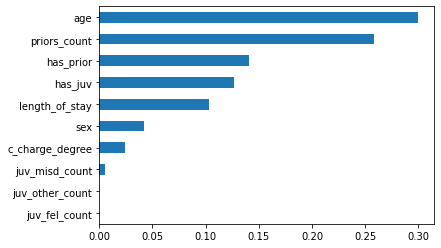

In [146]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(20).plot(kind='barh')